## **4. Keywords Clustering** 
We will compare different models implemeting each of these parameters:
- K-Means vs Expectation maximization VS Agglomerative algorithm
- Cosine vs euclidean distance 
- One-hot vs Sentence transformers embedding
- 50, 100, 150, 200 extracted features

*En grande partie basé sur le tutoriel suivant* :   
https://colab.research.google.com/drive/1HHNFjKlip1AaFIuvvn0AicWyv6egLOZw?usp=sharing#scrollTo=zhP1daroRzRV    
(Une approche à base de Word embedding - on pourrait utiliser les scores TF-IDF ou OKapi pour les traits discriminants plutôt que la fréquence (voir plus bas))

In [31]:
from pandas import *
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn import metrics
import matplotlib.pyplot as plt
from collections import Counter

In [32]:
algorithmes = ['K-means', 'Expectation-Maximization', 'AgglomerativeClustering']
embeddings = ['One-Hot', 'Sentence transformers']
features = [50, 100, 150, 200]

results = []
for algorithme in algorithmes:
    for embedding in embeddings:
            results.append(\
            {'algorithme' : algorithme,\
                'embedding': embedding, \
                'N features': None, \
                'K (nb clusters)' : None,\
                'Score Silhouette': None})


# On va remplir ce dictionnaire avec les bons scores au fur et à mesure qu'on expérimente
results = DataFrame(results)
results

,algorithme,embedding,N features,K (nb clusters),Score Silhouette
0,K-means,One-Hot,None,None,None
1,K-means,Sentence transformers,None,None,None
2,Expectation-Maximization,One-Hot,None,None,None
3,Expectation-Maximization,Sentence transformers,None,None,None
4,AgglomerativeClustering,One-Hot,None,None,None
5,AgglomerativeClustering,Sentence transformers,None,None,None


**Importer la liste de termes candidats avec leur fréquence**

In [33]:
# path = '../05-transformation/'
# acteur = 'pinel'

# csv_file = acteur + '_weighting_OKapiBM25.csv'

In [34]:
import glob
import pandas as pd

# get data file names
path ='../05-transformation'
filenames = glob.glob(path + "/*.csv")

dfs = []
for filename in filenames:
    dfs.append(pd.read_csv(filename))

# Concatenate all data into one DataFrame
big_frame = pd.concat(dfs, ignore_index=True).drop(columns=["Unnamed: 0"])

In [35]:
big_frame['TF + DF']= big_frame['Fréquence (TF)'] + big_frame['Fréquence documentaire (DF)']


big_frame

,Corpus,Terme,Structure syntaxique,Fréquence (TF),Fréquence documentaire (DF),LLR,isMeSHTerm,isTaxoTerm,Terme formatté,TF (sklearn),DF (sklearn),TF-IDF,OkapiBM25,TF + DF
0,pinel,familles,NOM,16,10,-,False,False,familles,16,10,0.185250,27.361918,26
1,pinel,strategies,NOM,36,4,-,False,False,strategies,36,4,0.020831,26.353850,40
2,pinel,visite,NOM,34,18,-,False,False,visite,34,18,0.795024,24.855460,52
3,pinel,eau,NOM,24,66,-,False,True,eau,4,4,0.002315,23.101577,90
4,pinel,sars-cov-2,NOM,60,4,-,False,False,sars_cov_2,60,4,0.034718,22.689984,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,pinel,coronavirus,NOM,64,4,-,False,False,coronavirus,64,4,0.037032,0.000000,68
670,pinel,health setting,NOM ADJ,16,4,131.80601647055443,False,False,health setting,16,4,0.009258,0.000000,20
671,pinel,valorisation,NOM,18,16,-,False,False,valorisation,18,16,0.216057,0.000000,34
672,pinel,forensic,NOM,76,4,-,False,False,forensic,72,4,0.041661,0.000000,80


In [36]:
#csv = big_frame[big_frame['isMeSHTerm'] == True].drop(columns = ['Terme formatté', 'TF (sklearn)', 'DF (sklearn)'])

csv = big_frame.drop(columns = ['Terme formatté', 'TF (sklearn)', 'DF (sklearn)'])

In [37]:
from pandas import *

# with open(path+csv_file, encoding='utf-8') as f:
#     csv = read_csv(f).drop(columns = ['Unnamed: 0', 'Terme formatté', 'TF (sklearn)', 'DF (sklearn)']) #[['Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)']]
#     csv['TF + DF']= csv['Fréquence (TF)'] + csv['Fréquence documentaire (DF)']
#     # Test
#     csv = csv[csv['isMeSHTerm'] == True]
# csv

*Embedding : One-hot encoding*  
> One Hot encoding is a representation of categorical variables as binary vectors. Each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1.

*Créer une fonction avec N en paramètres = nombre de features retenus souhaités*

In [ ]:
N = 100

In [38]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer("(\w+\'|\w+-\w+|\(|\)|\w+)")

file_path = "../04-filtrage/stopwords.txt"
with open(file_path, 'r', encoding="utf-8") as f:
    stopwords = [t.lower().strip('\n') for t in f.readlines()]

def to_tokens(kw, min_chars=2):
    """
    Transforms sentence to list of tokens.  

    Basic: transform special characters to ascii + lowercase.  
    Options:  
    - remove stopwords (provide list of stopwords)  
    - set minimum length for tokens: will remove any shorter token. 
    
    Returns sorted tokens
    """
    tokens = tokenizer.tokenize(kw) # split the string into a list of words
    tokens = [word for word in tokens if len(word) > min_chars] 
    tokens = [word for word in tokens if word not in stopwords] 
    
    tokens = set(tokens) # to remove duplicates
    tokens = sorted(tokens) # converts our set back to a list and sorts words in alphabetical order
    return tokens

In [39]:
keywords_oh = csv.drop(columns=['Structure syntaxique', "LLR", "TF-IDF",	"OkapiBM25"])[["Corpus",	"Terme", "Fréquence (TF)",	"Fréquence documentaire (DF)", "TF + DF", "isMeSHTerm",	"isTaxoTerm"]]

In [40]:
keywords_oh["tokens"] = keywords_oh["Terme"].apply(lambda x: to_tokens(
    x,
    min_chars=2,
))

## Test - ça fait pas beaucoup de sens de cluster des unigrammes, on va donc seulement retenir des n-grammes où n est au-dessus de 2
# keywords_oh["len"] = keywords_oh["tokens"].apply(lambda x : len(x))
# keywords_oh = keywords_oh[keywords_oh['len'] > 1].drop(columns=["len"])

In [41]:
keywords_oh

,Corpus,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,isMeSHTerm,isTaxoTerm,tokens
0,pinel,familles,16,10,26,False,False,[familles]
1,pinel,strategies,36,4,40,False,False,[strategies]
2,pinel,visite,34,18,52,False,False,[visite]
3,pinel,eau,24,66,90,False,True,[eau]
4,pinel,sars-cov-2,60,4,64,False,False,[sars-cov]
...,...,...,...,...,...,...,...,...
669,pinel,coronavirus,64,4,68,False,False,[coronavirus]
670,pinel,health setting,16,4,20,False,False,"[health, setting]"
671,pinel,valorisation,18,16,34,False,False,[valorisation]
672,pinel,forensic,76,4,80,False,False,[forensic]


In [42]:
def to_vector(keyword,vocab):
    """
    Calculates vector of keyword on given vocabulary.

    Returns vector as a list of values.  
    """
    vector = []
    for word in vocab:
        if word in keyword:
            vector.append(1)
        else:
            vector.append(0)
    return vector

In [43]:
# Cette fontion prend en paramètres :
# - un DataFrame qui contient un champ où sont consignés des vecteurs contenant les tokens de chaque mot-clé
# - le nombre de features maximal qui doit être retenu pour constituer le plongement lexical (embedding)

# Elle retourne le dataframe où une colonne 'vector' a été ajoutée avec le bon nombre de features

def features_embeddings(df, n_features):
    vocab = sorted(set(df["tokens"].explode()))
    len(vocab)

    counter = Counter(df["tokens"].explode().to_list())
    vocab = []

    # Ici, ça pourrait être intéressant de retenir sur la base du score TF-IDF ou OKapi
    for key,value in counter.most_common(n_features):
        vocab.append(key)

    return vocab

vocab = features_embeddings(keywords_oh, N)

# Remarque : le type d'embedding qui est fait ici est du style 'One-hot encoding (binaire - si le terme est présent = 1, sinon 0) ; mais il existe d'autres manière de 
# représenter la matrice de cooccurrences qu'avec des scores binaires
keywords_oh["vector"] = keywords_oh["tokens"].apply(lambda x: to_vector(x,vocab))
keywords_oh

,Corpus,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,isMeSHTerm,isTaxoTerm,tokens,vector
0,pinel,familles,16,10,26,False,False,[familles],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,pinel,strategies,36,4,40,False,False,[strategies],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,pinel,visite,34,18,52,False,False,[visite],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,pinel,eau,24,66,90,False,True,[eau],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,pinel,sars-cov-2,60,4,64,False,False,[sars-cov],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
669,pinel,coronavirus,64,4,68,False,False,[coronavirus],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
670,pinel,health setting,16,4,20,False,False,"[health, setting]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
671,pinel,valorisation,18,16,34,False,False,[valorisation],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
672,pinel,forensic,76,4,80,False,False,[forensic],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [44]:
# Par exemple, on va créer différents embeddings basés respectivement sur 50, 100, 150 et 200 features puis on va tester les résultats qu'on obtient avec 
# ces différentes valeurs
for f in features:
    vocab = features_embeddings(keywords_oh, f)

In [45]:
keywords_oh

,Corpus,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,isMeSHTerm,isTaxoTerm,tokens,vector
0,pinel,familles,16,10,26,False,False,[familles],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,pinel,strategies,36,4,40,False,False,[strategies],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,pinel,visite,34,18,52,False,False,[visite],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,pinel,eau,24,66,90,False,True,[eau],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,pinel,sars-cov-2,60,4,64,False,False,[sars-cov],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
669,pinel,coronavirus,64,4,68,False,False,[coronavirus],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
670,pinel,health setting,16,4,20,False,False,"[health, setting]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
671,pinel,valorisation,18,16,34,False,False,[valorisation],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
672,pinel,forensic,76,4,80,False,False,[forensic],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [46]:
keywords_oh

,Corpus,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,isMeSHTerm,isTaxoTerm,tokens,vector
0,pinel,familles,16,10,26,False,False,[familles],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,pinel,strategies,36,4,40,False,False,[strategies],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,pinel,visite,34,18,52,False,False,[visite],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,pinel,eau,24,66,90,False,True,[eau],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,pinel,sars-cov-2,60,4,64,False,False,[sars-cov],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...
669,pinel,coronavirus,64,4,68,False,False,[coronavirus],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
670,pinel,health setting,16,4,20,False,False,"[health, setting]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
671,pinel,valorisation,18,16,34,False,False,[valorisation],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
672,pinel,forensic,76,4,80,False,False,[forensic],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


*Embedding : Sentence transformers*  

> "A **transformer** is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part  of the input data.
Transformers are increasingly the model of choice for NLP problems, replacing RNN models such as long short-term memory (LSTM). The additional  training parallelization allows training on larger datasets. This led to the development of pretrained systems such as BERT (Bidirectional Encoder Representations from Transformers) and GPT (Generative Pre-trained Transformer), which were trained with large language datasets, such as the Wikipedia Corpus and Common Crawl, and can be fine-tuned for specific tasks."   
  
(https://en.wikipedia.org/wiki/Transformer_(machine_learning_model))


In [47]:
# On va utiliser un modèle BERT/sentence transformers (fr) pour extraire nos embeddings plutôt que des simples one-hot encoding
from sentence_transformers import SentenceTransformer
model =  SentenceTransformer("dangvantuan/sentence-camembert-base")

keywords_st = csv

## Test - ça fait pas beaucoup de sens de cluster des unigrammes, on va donc seulement retenir des n-grammes où n est au-dessus de 2
keywords_st["tokens"] = csv["Terme"].apply(lambda x: to_tokens(
    x,
    min_chars=2,
))

# keywords_st["len"] = keywords_st["tokens"].apply(lambda x : len(x))
# keywords_st = keywords_st[keywords_st['len'] > 1].drop(columns=["len"])

sentences = keywords_st['Terme'].tolist()

#### **K-means clustering** (*sklearn*)


*Un premier essai sur nos one-hot embeddings*

In [48]:
# On va créer une fonction qui prend en paramètre un embeddings (une liste de vecteurs) et qui calcule les K-moyens pour celle-ci en considérant un 
# différent nombre de clusters et retourne le score silhouette le plus élevé 

# Pour l'instant ça marche pas

In [62]:

K = range(20, len(vocab))
silhouette_scores = []

for k in K:
    X = keywords_oh["vector"].to_list()
    km = KMeans(n_clusters=k, init='k-means++', algorithm='elkan', max_iter=200, n_init=1).fit(X)

    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the k-means result.
    svd = TruncatedSVD(n_components= round(k/4))
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)
    km.fit(X)

    labels = km.labels_
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])


print("Score Silhouette")
print("On va regrouper nos termes en " + str(true_k) + " clusters.")
df

Score Silhouette
On va regrouper nos termes en 25 clusters.


,Nombre de clusters (k),Score Silhouette
0,20,0.938478
1,21,0.932458
2,22,0.933177
3,23,0.928259
4,24,0.927214
...,...,...
175,195,0.755936
176,196,0.757580
177,197,0.758698
178,198,0.756006


In [64]:
algorithme = 'K-means'
embedding = 'One-Hot'
distance = 'Euclidean'
features = len(vocab)
results['N features'] = features

def add_results(algo, embed, dist, n_f):
    results.loc[ \
        (results['algorithme'] == algorithme) & \
        (results['embedding'] == embedding), 'N features'] = features

    results.loc[ \
        (results['algorithme'] == algorithme) & \
        (results['embedding'] == embedding), 'distance'] = distance

    results.loc[ \
        (results['algorithme'] == algorithme) & \
        (results['embedding'] == embedding), 'K (nb clusters)'] = true_k

    results.loc[ \
        (results['algorithme'] == algorithme) & \
        (results['embedding'] == embedding), 'Score Silhouette'] = df['Score Silhouette'].max()

    return results

add_results(algorithme, embedding, distance, features)

results

,algorithme,embedding,N features,K (nb clusters),Score Silhouette,distance
0,K-means,One-Hot,200,25,0.938481,Euclidean
1,K-means,Sentence transformers,200,None,None,NaN
2,Expectation-Maximization,One-Hot,200,None,None,NaN
3,Expectation-Maximization,Sentence transformers,200,None,None,NaN
4,AgglomerativeClustering,One-Hot,200,None,None,NaN
5,AgglomerativeClustering,Sentence transformers,200,None,None,NaN


In [65]:
X = keywords_oh["vector"].to_list()
km = KMeans(n_clusters=true_k, init='k-means++', algorithm='elkan', max_iter=200, n_init=1).fit(X)

# Run LSA
# Since LSA/SVD results are not normalized,
# we redo the normalization to improve the k-means result.
svd = TruncatedSVD(n_components=round(true_k/4))
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)
km.fit(X)

labels = km.labels_
keywords_oh["kmeans"] = list(km.labels_)

keywords_oh

,Corpus,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,isMeSHTerm,isTaxoTerm,tokens,vector,kmeans
0,pinel,familles,16,10,26,False,False,[familles],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
1,pinel,strategies,36,4,40,False,False,[strategies],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,pinel,visite,34,18,52,False,False,[visite],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,pinel,eau,24,66,90,False,True,[eau],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,pinel,sars-cov-2,60,4,64,False,False,[sars-cov],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...,...,...,...,...,...
669,pinel,coronavirus,64,4,68,False,False,[coronavirus],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
670,pinel,health setting,16,4,20,False,False,"[health, setting]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
671,pinel,valorisation,18,16,34,False,False,[valorisation],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
672,pinel,forensic,76,4,80,False,False,[forensic],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0


In [66]:
current_labels = set(km.labels_.tolist())

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_oh[keywords_oh["kmeans"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_oh['Cluster_kmeans_euclidean'] = keywords_oh['kmeans'].map(desired_labels)

In [67]:
#keywords = keywords[['Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'Cluster']]
keywords_oh.sort_values(["Cluster_kmeans_euclidean"], 
        axis=0,
        ascending=[False], 
        inplace=True)

In [68]:
#keywords = keywords.drop(columns=['TF + DF', 'tokens', 'vector', 'kmeans'])

keywords_oh = keywords_oh[['Corpus', 'Cluster_kmeans_euclidean', 'Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'TF + DF', 'isMeSHTerm', 'isTaxoTerm', 'vector', 'kmeans']]
keywords_oh = keywords_oh.sort_values(['Cluster_kmeans_euclidean', 'Fréquence (TF)', 'Fréquence documentaire (DF)'],
              ascending = [True, False, False])

keywords_oh

,Corpus,Cluster_kmeans_euclidean,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF,isMeSHTerm,isTaxoTerm,vector,kmeans
188,pinel,autochtones,autochtones,94,22,116,False,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10
474,pinel,autochtones,problématiques,44,28,72,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10
384,pinel,autochtones,émergence de problématiques,24,22,46,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10
410,pinel,autochtones,populations autochtones,22,22,44,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10
330,pinel,autochtones,cheminement de vie des autochtones,22,22,44,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10
...,...,...,...,...,...,...,...,...,...,...
414,pinel,sécurité,séance publique annuelle,16,8,24,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
176,pinel,sécurité,séance publique,16,8,24,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5
502,pinel,vie,vie,60,52,112,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19
35,pinel,vie,cheminement,30,28,58,False,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",19


In [70]:
base_path = '../06-clustering/'
file_path = base_path + '_KMeans_onehot_euclidiean.csv'
keywords_oh.drop(columns=['vector', 'kmeans']).to_csv(file_path)

In [71]:
#keywords_oh.groupby("Cluster_kmeans_euclidean")["Terme"].count()

#### *Visualisation*

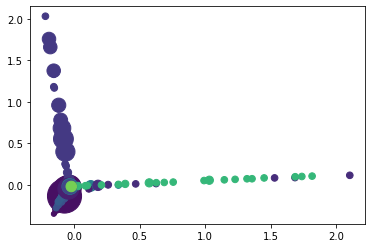

In [72]:
from sklearn.decomposition import PCA

vectors = keywords_oh["vector"].to_list()

pca = PCA(n_components=2).fit(vectors)
pca_2d = pca.transform(vectors)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords_oh["kmeans"], s=keywords_oh["TF + DF"])

#### **K-means clustering** (*sklearn*)


*Un deuxième essai, cette fois sur sur nos transformers embeddings*

In [74]:
K = range(20,len(vocab))
#Sum_of_squared_distances = []
silhouette_scores = []

for k in K:
    #true_k = int(input())
    X = embeddings
    kmeans = KMeans(n_clusters=k, init='k-means++', algorithm='elkan', max_iter=200, n_init=1).fit(X)
    #Sum_of_squared_distances.append(kmeans.inertia_)

    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the k-means result.
    svd = TruncatedSVD(n_components=round(k/4))
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)
    kmeans.fit(X)

    labels = kmeans.labels_
    #keywords["Cluster"] = list(kmeans.labels_)

    #original_space_centroids = svd.inverse_transform(X)
    #order_centroids = original_space_centroids.argsort()[:, ::-1]
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

# print("Méthode Elbow")
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

print("Score Silhouette")
print("On va regrouper nos termes en " + str(true_k) + " clusters.")
df

Score Silhouette
On va regrouper nos termes en 21 clusters.


,Nombre de clusters (k),Score Silhouette
0,20,0.957137
1,21,0.963807
2,22,0.912262
3,23,0.855499
4,24,0.908645
...,...,...
175,195,0.761205
176,196,0.761431
177,197,0.754155
178,198,0.757083


In [ ]:
algorithme = 'K-means'
embedding = 'Sentence transformers'
distance = 'Euclidean'
features = len(vocab)

add_results(algorithme, embedding, distance, features)

,algorithme,embedding,N features,K (nb clusters),Score Silhouette,distance
0,K-means,One-Hot,200,25,0.938481,Euclidean
1,K-means,Sentence transformers,200,21,0.963807,Euclidean
2,Expectation-Maximization,One-Hot,200,None,None,NaN
3,Expectation-Maximization,Sentence transformers,200,None,None,NaN
4,AgglomerativeClustering,One-Hot,200,None,None,NaN
5,AgglomerativeClustering,Sentence transformers,200,None,None,NaN


In [76]:
X = embeddings
kmeans = KMeans(n_clusters=true_k, init='k-means++', algorithm='elkan', max_iter=200, n_init=1).fit(X)

# Run LSA
# Since LSA/SVD results are not normalized,
# we redo the normalization to improve the k-means result.
svd = TruncatedSVD(n_components=true_k)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)
kmeans.fit(X)

labels = kmeans.labels_
keywords_st["kmeans"] = list(kmeans.labels_)

keywords_st


,Corpus,Terme,Structure syntaxique,Fréquence (TF),Fréquence documentaire (DF),LLR,isMeSHTerm,isTaxoTerm,TF-IDF,OkapiBM25,TF + DF,tokens,kmeans
0,pinel,familles,NOM,16,10,-,False,False,0.185250,27.361918,26,[familles],1
1,pinel,strategies,NOM,36,4,-,False,False,0.020831,26.353850,40,[strategies],1
2,pinel,visite,NOM,34,18,-,False,False,0.795024,24.855460,52,[visite],1
3,pinel,eau,NOM,24,66,-,False,True,0.002315,23.101577,90,[eau],1
4,pinel,sars-cov-2,NOM,60,4,-,False,False,0.034718,22.689984,64,[sars-cov],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,pinel,coronavirus,NOM,64,4,-,False,False,0.037032,0.000000,68,[coronavirus],1
670,pinel,health setting,NOM ADJ,16,4,131.80601647055443,False,False,0.009258,0.000000,20,"[health, setting]",12
671,pinel,valorisation,NOM,18,16,-,False,False,0.216057,0.000000,34,[valorisation],1
672,pinel,forensic,NOM,76,4,-,False,False,0.041661,0.000000,80,[forensic],1


In [77]:
current_labels = set(kmeans.labels_.tolist())

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_st[keywords_st["kmeans"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_st['Cluster_kmeans_euclidean'] = keywords_st['kmeans'].map(desired_labels)

In [78]:
#keywords = keywords[['Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'Cluster']]
keywords_st.sort_values(["Cluster_kmeans_euclidean"], 
        axis=0,
        ascending=[False], 
        inplace=True)

In [79]:
#keywords = keywords.drop(columns=['TF + DF', 'tokens', 'vector', 'kmeans'])

keywords_st = keywords_st[['Corpus', 'Cluster_kmeans_euclidean', 'kmeans', 'Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'TF + DF']]
keywords_st = keywords_st.sort_values(['Cluster_kmeans_euclidean', 'Fréquence (TF)', 'Fréquence documentaire (DF)'],
              ascending = [True, False, False])

keywords_st

,Corpus,Cluster_kmeans_euclidean,kmeans,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF
188,pinel,autochtones,14,autochtones,94,22,116
472,pinel,autochtones,14,populations,78,30,108
502,pinel,autochtones,14,vie,60,52,112
474,pinel,autochtones,14,problématiques,44,28,72
35,pinel,autochtones,14,cheminement,30,28,58
...,...,...,...,...,...,...,...
591,pinel,temps,9,rappel,20,6,26
126,pinel,temps,9,liste de rappel,20,4,24
97,pinel,temps,9,statut liste de rappel,16,4,20
664,pinel,temps,9,statut liste,16,4,20


In [80]:
base_path = '../06-clustering/'
file_path = base_path + '_KMeans_transformers_euclidean.csv'
keywords_st.to_csv(file_path)

In [81]:
keywords_st.groupby("Cluster_kmeans_euclidean")["Terme"].count()

keywords_st

,Corpus,Cluster_kmeans_euclidean,kmeans,Terme,Fréquence (TF),Fréquence documentaire (DF),TF + DF
188,pinel,autochtones,14,autochtones,94,22,116
472,pinel,autochtones,14,populations,78,30,108
502,pinel,autochtones,14,vie,60,52,112
474,pinel,autochtones,14,problématiques,44,28,72
35,pinel,autochtones,14,cheminement,30,28,58
...,...,...,...,...,...,...,...
591,pinel,temps,9,rappel,20,6,26
126,pinel,temps,9,liste de rappel,20,4,24
97,pinel,temps,9,statut liste de rappel,16,4,20
664,pinel,temps,9,statut liste,16,4,20


#### *Visualisation*

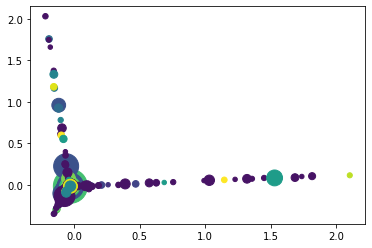

In [83]:
from sklearn.decomposition import PCA

vectors = embeddings

pca = PCA(n_components=2).fit(vectors)
pca_2d = pca.transform(vectors)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords_st['kmeans'], s=keywords_oh["TF + DF"])

### **K-means clustering** (*NLTK*)

Le but d'utiliser NLTK est de pouvoir prendre la distance cosinus entre les vecteurs plutôt que la distance Euclidienne, pour les embeddings basés sur le sentence transformer.

In [84]:
from nltk import cluster
from nltk.cluster import KMeansClusterer
from nltk.cluster import cosine_distance
from nltk.cluster import euclidean_distance
import nltk
import numpy as np
from numpy import array, ndarray
  
from sklearn import metrics

In [85]:
# initialise the clusterer (will also assign the vectors to clusters)

K = range(20,len(vocab))
silhouette_scores = []
for k in K:
    X = embeddings
    clusterer = cluster.KMeansClusterer(true_k, distance=cosine_distance, avoid_empty_clusters=True, repeats=25)
    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the result.
    svd = TruncatedSVD(n_components=round(k/4))
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(X)
    labels = clusterer.cluster(X, assign_clusters= True)
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

df[df['Nombre de clusters (k)'] == true_k]
df

/Users/camilledemers/opt/anaconda3/lib/python3.9/site-packages/nltk/cluster/util.py:130: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (numpy.dot(u, v) / (sqrt(numpy.dot(u, u)) * sqrt(numpy.dot(v, v))))


In [ ]:
algorithme = 'K-means'
embedding = 'Sentence transformers'
distance = 'cosine'
features = len(vocab)

add_results(algorithme, embedding, distance, features)

results

In [ ]:
keywords_oh

In [ ]:
keywords_st["kmeans_cosine"] = list(labels)

In [ ]:
current_labels = set(labels)

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_st[keywords_st["kmeans_cosine"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_st['Cluster_kmeans_cosine'] = keywords_st['kmeans_cosine'].map(desired_labels)

keywords_st

### **EM clustering** (*sklearn*)

> L'algorithme espérance-maximisation (en anglais expectation-maximization algorithm, souvent abrégé EM), est un algorithme itératif qui permet de trouver les paramètres du maximum de vraisemblance d'un modèle probabiliste lorsque ce dernier dépend de variables latentes non observables. 

(https://fr.wikipedia.org/wiki/Algorithme_esp%C3%A9rance-maximisation)

**sklearn.mixture GaussianMixture**  
https://www.analyticsvidhya.com/blog/2019/10/gaussian-mixture-models-clustering/  
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html

*Encore une fois, on fait un premier essai sur nos one-hot embeddings*

In [ ]:
from sklearn.mixture import GaussianMixture

K = range(20,len(vocab))
silhouette_scores = []
for k in K:
    X = keywords_oh["vector"].to_list()
    gmm = GaussianMixture(n_components=k, init_params='k-means++').fit(X)
    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the result.
    svd = TruncatedSVD(n_components=k)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(X)
    gmm.fit(X)
    labels = gmm.predict(X)
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

df[df['Nombre de clusters (k)'] == true_k]

In [ ]:
algorithme = 'Expectation-Maximization'
embedding = 'One-Hot'
distance = None
features = len(vocab)

add_results(algorithme, embedding, distance, features)

results

In [ ]:
keywords_oh["E-M"] = list(labels)
current_labels = set(labels)

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_oh[keywords_oh["E-M"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_oh['Cluster_E-M'] = keywords_oh['E-M'].map(desired_labels)

keywords_oh

In [ ]:
vectors = keywords_oh["vector"].tolist()

pca = PCA(n_components=2).fit(vectors)
pca_2d = pca.transform(vectors)

plt.scatter(pca_2d[:,0], pca_2d[:,1], c=keywords_oh["GMM"], s=keywords_oh["TF + DF"])

In [ ]:
current_labels = set(labels)

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_oh[keywords_oh["GMM"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_oh['Cluster_GMM'] = keywords_oh['GMM'].map(desired_labels)

In [ ]:
#keywords_oh = keywords_oh[['Cluster_kmeans_euclidean', 'Cluster_GMM', 'Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'TF + DF']]
keywords_oh = keywords_oh[['Corpus', 'Cluster_kmeans_euclidean', 'Cluster_GMM', 'Terme', 'Fréquence (TF)', 'Fréquence documentaire (DF)', 'TF + DF', 'isMeSHTerm', 'isTaxoTerm', 'vector', 'kmeans']]
keywords_oh

*Deuxième essai, cette fois sur les sentence embeddings / transformers*

In [ ]:
K = range(20,len(vocab))
silhouette_scores = []
for k in K:
    X = embeddings
    gmm = GaussianMixture(n_components=k, init_params='k-means++').fit(X)
    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the result.
    svd = TruncatedSVD(n_components=round(k/4))
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    X = lsa.fit_transform(X)
    gmm.fit(X)
    labels = gmm.predict(X)
    silhouette_scores.append([k, metrics.silhouette_score(X, labels)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

df[df['Nombre de clusters (k)'] == true_k]

In [ ]:
algorithme = 'E-M'
embedding = 'Sentence transformers'
distance = None
features = len(vocab)

add_results(algorithme, embedding, distance, features)
results

[...] to do : ajouter le EM clustering / sklearn avec le sentence embeddings

En fait je ne suis pas convaincue, parce que dans tous les cas ça ne donne jamais d'aussi bons résultats avec les sentence embeddings quant au scoresilhouette ; peut-être plus tard, mais peut-être pas une priorité.

### **EM clustering** (*NLTK*)

*Premier essai, sur les one-hot embeddings / bag-of-words*

Pas prioritaire non plus puisqu'on a déjà le EM Clustering fonctionnel avec celui de sk-learn

In [ ]:
# from nltk import cluster
# from nltk.cluster import KMeansClusterer, euclidean_distance

# #On initialise sur les kmeans
# vectors = [array(f) for f in keywords_oh['vector'].tolist()]

# clusterer = KMeansClusterer(true_k, euclidean_distance, initial_means=None, repeats=10)
# means = clusterer.cluster(vectors, True, trace=True)

# ##########
# clusterer = cluster.EMClusterer(means, bias=0.1)
# clusters = clusterer.cluster(vectors, True, trace=True)



*Deuxième essai, cette fois sur les sentence embeddings / transformers*  
(même chose)

In [ ]:
###########

### **Agglomerative clustering** (*NLTK / sklearn*)
> In data mining and statistics, hierarchical clustering (also called hierarchical cluster analysis or HCA) is a method of cluster analysis which seeks to build a hierarchy of clusters. Strategies for hierarchical clustering generally fall into two types:  
> - Agglomerative: This is a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.
> - Divisive: This is a "top-down" approach: all observations start in one cluster, and splits are performed recursively as one moves down the hierarchy.    
  
(https://en.wikipedia.org/wiki/Hierarchical_clustering)

**sklearn AgglomerativeClustering / one-hot embeddings**  
(le clusterer agglomératif de sklearn, qui permet d'utiliser la distance Euclidienne, mais pas celui d'NLTK)*

In [ ]:
from sklearn.cluster import AgglomerativeClustering

K = range(20,50)
Sum_of_squared_distances = []
silhouette_scores = []

for k in K:
    X = keywords_oh['vector'].tolist()
    clustering = AgglomerativeClustering().fit(X)

    #Sum_of_squared_distances.append(km.inertia_)

    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the k-means result.
    svd = TruncatedSVD(n_components=round(k/4))
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    clusters = clustering.labels_
    #keywords["Cluster"] = list(kmeans.labels_)

    #original_space_centroids = svd.inverse_transform(X)
    #order_centroids = original_space_centroids.argsort()[:, ::-1]
    silhouette_scores.append([k, metrics.silhouette_score(X, clusters)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

# print("Méthode Elbow")
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

print("Score Silhouette")
print("On va regrouper nos termes en " + str(true_k) + " clusters.")
df

In [ ]:
algorithme = 'AgglomerativeClustering'
embedding = 'One-Hot'
distance = 'Euclidean'
features = len(vocab)

add_results(algorithme, embedding, distance, features)

results

**NLTK Group Average Agglomerative Clustering (GAAC) / Sentence transformers embeddings**

In [ ]:
from nltk.cluster import GAAClusterer

K = range(20,50)
Sum_of_squared_distances = []
silhouette_scores = []

for k in K:
    X = embeddings
    clusterer = GAAClusterer(k)

    #Sum_of_squared_distances.append(km.inertia_)

    # Run LSA
    # Since LSA/SVD results are not normalized,
    # we redo the normalization to improve the k-means result.
    svd = TruncatedSVD(n_components=round(k/4))
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)

    X = lsa.fit_transform(X)

    clusters = clusterer.cluster(X, True)
    #keywords["Cluster"] = list(kmeans.labels_)

    #original_space_centroids = svd.inverse_transform(X)
    #order_centroids = original_space_centroids.argsort()[:, ::-1]
    silhouette_scores.append([k, metrics.silhouette_score(X, clusters)])

df = DataFrame(silhouette_scores, columns=['Nombre de clusters (k)', 'Score Silhouette'])
true_k = int(df[df['Score Silhouette'] == df['Score Silhouette'].max()]['Nombre de clusters (k)'])

# print("Méthode Elbow")
# plt.plot(K, Sum_of_squared_distances, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Sum_of_squared_distances')
# plt.title('Elbow Method For Optimal k')
# plt.show()

print("Score Silhouette")
print("On va regrouper nos termes en " + str(true_k) + " clusters.")
df

In [ ]:
algorithme = 'AgglomerativeClustering'
embedding = 'Sentence transformers'
distance = 'Cosine'
features = len(vocab)

add_results(algorithme, embedding, distance, features)

results

In [ ]:
from nltk.cluster import GAAClusterer

# use a set of tokens with 2D indices
vectors = embeddings

# test the GAAC clusterer with 4 clusters
clusterer = GAAClusterer(50)
clusters = clusterer.cluster(vectors, True)

keywords_st["GAAC"] = clusters

current_labels = set(clusters)

desired_labels = {x : None for x in current_labels} # (on initialise à None)

for label in current_labels:
    cluster = keywords_oh[keywords_st["GAAC"] == label]
    max_freq = cluster['TF + DF'].max()
    new_label = cluster[cluster['TF + DF'] == max_freq]['Terme'].values[0]

    desired_labels[label] = new_label

keywords_st['Cluster_GAAC'] = keywords_st['GAAC'].map(desired_labels)


In [ ]:
keywords_st

### **Résultats**

In [ ]:
results